В этом ноутбуке мы попробуем обучить GAN генерировать морды кошек из случайного шума. Датасет с кошками взят отсюда:
https://www.kaggle.com/spandan2/cats-faces-64x64-for-generative-models

In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [2]:
!unzip archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: cats/cats/5499.jpg      
  inflating: cats/cats/55.jpg        
  inflating: cats/cats/550.jpg       
  inflating: cats/cats/5500.jpg      
  inflating: cats/cats/5501.jpg      
  inflating: cats/cats/5502.jpg      
  inflating: cats/cats/5503.jpg      
  inflating: cats/cats/5504.jpg      
  inflating: cats/cats/5505.jpg      
  inflating: cats/cats/5506.jpg      
  inflating: cats/cats/5507.jpg      
  inflating: cats/cats/5508.jpg      
  inflating: cats/cats/5509.jpg      
  inflating: cats/cats/551.jpg       
  inflating: cats/cats/5510.jpg      
  inflating: cats/cats/5511.jpg      
  inflating: cats/cats/5512.jpg      
  inflating: cats/cats/5513.jpg      
  inflating: cats/cats/5514.jpg      
  inflating: cats/cats/5515.jpg      
  inflating: cats/cats/5516.jpg      
  inflating: cats/cats/5517.jpg      
  inflating: cats/cats/5518.jpg      
  inflating: cats/cats/5519.jpg      
  inflating: cats/cats/552.jpg       

In [2]:
DATA_DIR = './cats/'
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [3]:
train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

In [4]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [5]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

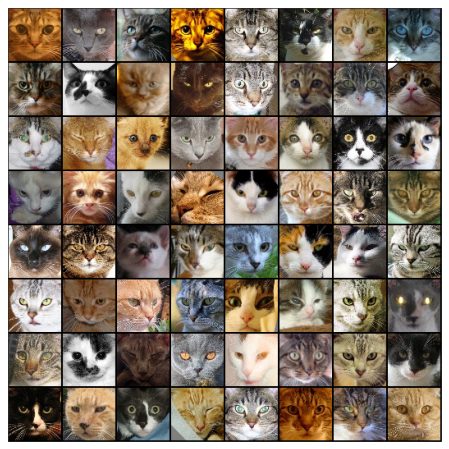

In [6]:
show_batch(train_dl)

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [8]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [9]:
train_dl = DeviceDataLoader(train_dl, device)

In [10]:
from torch.nn.modules.activation import LeakyReLU
from torch.nn.modules.batchnorm import BatchNorm2d
discriminator = nn.Sequential(
    
    # in: 3 x 64 x 64 RGB ad size in pixels
    nn.Conv2d(3, 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace = True),
    # out = 64 32 32

    nn.Conv2d(64, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace = True),


    nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace = True),


    nn.Conv2d(256, 512, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace = True),

    nn.Conv2d(512, 1, kernel_size = 4, stride = 1, padding = 0, bias = False),

    nn.Flatten(),
    nn.Sigmoid()
)
discriminator = to_device(discriminator, device)

In [11]:
from torch.nn.modules.container import Sequential
latent_size = 128   #size of the input vector for generator

generator = nn.Sequential(
    # input size: latent_size x 1 x 1
    nn.ConvTranspose2d(latent_size, 512, kernel_size = 4, stride = 1, padding = 0, bias = False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),


    nn.ConvTranspose2d(128, 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 3, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.Tanh()

)



torch.Size([128, 3, 64, 64])


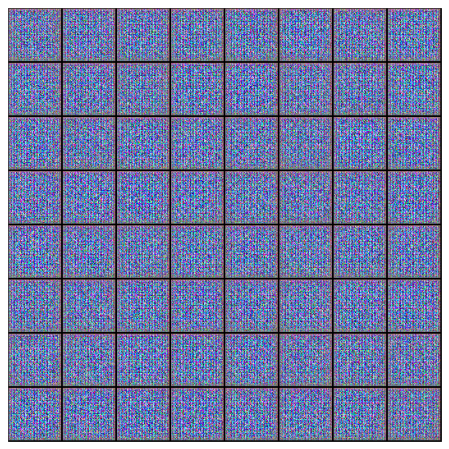

In [12]:
xb = torch.randn(batch_size, latent_size, 1, 1) 
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [13]:
# ========================================
# ========= Set Model and Loss ===========
# ========================================

model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}
lr = 0.0002
epochs = 40

In [14]:
generator = to_device(generator, device)
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [15]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [19]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            # set notch equal 1
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            # set notch equal zero
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())






            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            # set notch equal one
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
        # Save generated images
        if epoch == epochs - 1:
          save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [20]:
epochs = 50
history = fit(model, criterion, epochs, lr)

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [1/50], loss_g: 7.0938, loss_d: 0.5691, real_score: 0.8227, fake_score: 0.1829


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [2/50], loss_g: 4.3868, loss_d: 0.6274, real_score: 0.7901, fake_score: 0.2026


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [3/50], loss_g: 3.6467, loss_d: 0.7466, real_score: 0.7566, fake_score: 0.2519


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [4/50], loss_g: 3.7384, loss_d: 0.6994, real_score: 0.7603, fake_score: 0.2366


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [5/50], loss_g: 4.3214, loss_d: 0.7088, real_score: 0.7689, fake_score: 0.2270


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [6/50], loss_g: 4.5810, loss_d: 0.6835, real_score: 0.7796, fake_score: 0.2202


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [7/50], loss_g: 4.6741, loss_d: 0.7058, real_score: 0.7745, fake_score: 0.2228


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [8/50], loss_g: 4.7521, loss_d: 0.7045, real_score: 0.7805, fake_score: 0.2109


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [9/50], loss_g: 4.2232, loss_d: 0.7470, real_score: 0.7544, fake_score: 0.2522


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [10/50], loss_g: 4.7574, loss_d: 0.6059, real_score: 0.8030, fake_score: 0.1964


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [11/50], loss_g: 4.4757, loss_d: 0.6571, real_score: 0.7818, fake_score: 0.2174


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [12/50], loss_g: 4.5689, loss_d: 0.6335, real_score: 0.7950, fake_score: 0.2038


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [13/50], loss_g: 4.4565, loss_d: 0.6625, real_score: 0.7909, fake_score: 0.2035


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [14/50], loss_g: 4.5435, loss_d: 0.6454, real_score: 0.7952, fake_score: 0.2110


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [15/50], loss_g: 4.6648, loss_d: 0.5358, real_score: 0.8234, fake_score: 0.1795


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [16/50], loss_g: 4.6759, loss_d: 0.5600, real_score: 0.8190, fake_score: 0.1733


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [17/50], loss_g: 4.9899, loss_d: 0.5336, real_score: 0.8288, fake_score: 0.1710


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [18/50], loss_g: 4.7256, loss_d: 0.5247, real_score: 0.8357, fake_score: 0.1592


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [19/50], loss_g: 5.0048, loss_d: 0.4980, real_score: 0.8486, fake_score: 0.1535


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [20/50], loss_g: 4.8869, loss_d: 0.4517, real_score: 0.8527, fake_score: 0.1489


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [21/50], loss_g: 5.0168, loss_d: 0.4219, real_score: 0.8649, fake_score: 0.1354


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [22/50], loss_g: 5.2181, loss_d: 0.4122, real_score: 0.8689, fake_score: 0.1261


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [23/50], loss_g: 5.2689, loss_d: 0.4343, real_score: 0.8702, fake_score: 0.1325


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [24/50], loss_g: 5.4323, loss_d: 0.3059, real_score: 0.8974, fake_score: 0.0956


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [25/50], loss_g: 5.5732, loss_d: 0.3797, real_score: 0.8854, fake_score: 0.1234


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [26/50], loss_g: 5.5272, loss_d: 0.3417, real_score: 0.8927, fake_score: 0.1049


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [27/50], loss_g: 5.4977, loss_d: 0.3439, real_score: 0.8937, fake_score: 0.1004


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [28/50], loss_g: 5.7773, loss_d: 0.3759, real_score: 0.8933, fake_score: 0.1104


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [29/50], loss_g: 6.2407, loss_d: 0.2134, real_score: 0.9273, fake_score: 0.0747


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [30/50], loss_g: 5.7632, loss_d: 0.2771, real_score: 0.9134, fake_score: 0.0853


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [31/50], loss_g: 5.6806, loss_d: 0.3233, real_score: 0.8987, fake_score: 0.0946


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [32/50], loss_g: 5.1021, loss_d: 0.4046, real_score: 0.8704, fake_score: 0.1376


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [33/50], loss_g: 5.4901, loss_d: 0.3351, real_score: 0.9057, fake_score: 0.0923


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [34/50], loss_g: 5.5996, loss_d: 0.2409, real_score: 0.9184, fake_score: 0.0835


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [35/50], loss_g: 6.5302, loss_d: 0.2201, real_score: 0.9282, fake_score: 0.0708


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [36/50], loss_g: 6.0880, loss_d: 0.2570, real_score: 0.9241, fake_score: 0.0741


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [37/50], loss_g: 6.0220, loss_d: 0.1801, real_score: 0.9363, fake_score: 0.0656


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [38/50], loss_g: 6.3106, loss_d: 0.1342, real_score: 0.9488, fake_score: 0.0499


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [39/50], loss_g: 6.3916, loss_d: 0.2915, real_score: 0.9148, fake_score: 0.0861


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [40/50], loss_g: 6.0559, loss_d: 0.1724, real_score: 0.9355, fake_score: 0.0630


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [41/50], loss_g: 6.4350, loss_d: 0.2273, real_score: 0.9292, fake_score: 0.0729


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [42/50], loss_g: 5.7110, loss_d: 0.2771, real_score: 0.9230, fake_score: 0.0758


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [43/50], loss_g: 6.0386, loss_d: 0.1819, real_score: 0.9349, fake_score: 0.0650


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [44/50], loss_g: 6.9238, loss_d: 0.2178, real_score: 0.9281, fake_score: 0.0704


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [45/50], loss_g: 6.1563, loss_d: 0.2441, real_score: 0.9266, fake_score: 0.0721


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [46/50], loss_g: 6.1755, loss_d: 0.2313, real_score: 0.9294, fake_score: 0.0759


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [47/50], loss_g: 6.1756, loss_d: 0.2241, real_score: 0.9303, fake_score: 0.0681


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [48/50], loss_g: 6.0890, loss_d: 0.1921, real_score: 0.9349, fake_score: 0.0657


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [49/50], loss_g: 6.2364, loss_d: 0.2388, real_score: 0.9311, fake_score: 0.0701


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [50/50], loss_g: 6.0723, loss_d: 0.1896, real_score: 0.9400, fake_score: 0.0524
Saving generated-images-0050.png


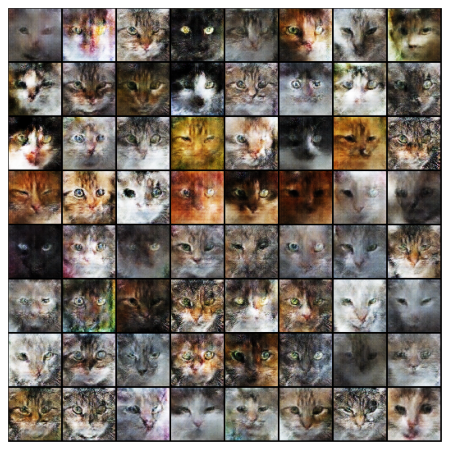

In [21]:
losses_g, losses_d, real_scores, fake_scores = history

generated_img = cv2.imread(f'./generated/generated-images-00{epochs}.png')
generated_img = generated_img[:, :, [2, 1, 0]]


fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)